In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

from sklearn.utils import resample
%matplotlib inline


In [2]:
tracks = pd.read_csv("spotify.csv", index_col =0)

tracks.dropna(inplace = True)

In [3]:
tracks.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre_group
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic_folk
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic_folk
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic_folk
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic_folk
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic_folk


In [4]:
# Function to sample each genre group
def stratified_sample(df, group_col, n_samples, random_state=42):
    return df.groupby(group_col, group_keys=False).apply(lambda x: x.sample(n=min(len(x), n_samples), random_state=random_state))

# Perform stratified sampling
tracks_sample = stratified_sample(tracks, 'genre_group', 7000)  # Sample 7000 tracks per genre

# Check the sampled data
print(tracks_sample['genre_group'].value_counts())


ambient          7000
electro          7000
acoustic_folk    7000
latin            7000
rock_metal       7000
dance            7000
pop              7000
hiphop_reggae    7000
happy_kids       7000
Name: genre_group, dtype: int64


In [5]:
tracks.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre_group
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic_folk
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic_folk
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic_folk
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic_folk
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic_folk


In [6]:
tracks_sample.drop(['album_name','track_name','track_id','artists', 'popularity', 'explicit', 'time_signature', "duration_ms"], axis=1, inplace = True)

In [7]:
data = tracks_sample.drop("genre_group", axis = 1)
target = tracks_sample["genre_group"].values


In [8]:
encoder = OneHotEncoder()
target = encoder.fit_transform(target.reshape(-1, 1)).toarray()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.1, random_state = 123, stratify=target)

In [10]:
scaler = StandardScaler() 

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

In [11]:
model = Sequential()
model.add(Dense(512, input_dim=X_train_sc.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3,
                                    episilon= 0.01,
                                    factor=0.1,
                                    cooldown = 4,
                                    verbose=1)

In [14]:
early_stopping = EarlyStopping(
                                patience=20, # Wait 20 epochs before application
                                min_delta = 0.01, #If the loss function does not vary more than +/-0.1% after 5 epochs, stop 
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss')

In [15]:
history = model.fit(X_train_sc, y_train, epochs=75, batch_size=64, validation_split=0.2, callbacks=[reduce_learning_rate, early_stopping])

Epoch 1/75
709/709 [==============================] - 3s 3ms/step - loss: 1.8129 - accuracy: 0.3462 - val_loss: 1.7168 - val_accuracy: 0.3813 - lr: 0.0010
Epoch 2/75
709/709 [==============================] - 2s 3ms/step - loss: 1.7198 - accuracy: 0.3874 - val_loss: 1.6981 - val_accuracy: 0.3854 - lr: 0.0010
Epoch 3/75
709/709 [==============================] - 2s 3ms/step - loss: 1.6893 - accuracy: 0.3983 - val_loss: 1.6656 - val_accuracy: 0.4001 - lr: 0.0010
Epoch 4/75
709/709 [==============================] - 2s 3ms/step - loss: 1.6638 - accuracy: 0.4052 - val_loss: 1.6636 - val_accuracy: 0.3979 - lr: 0.0010
Epoch 5/75
709/709 [==============================] - 2s 3ms/step - loss: 1.6532 - accuracy: 0.4100 - val_loss: 1.6461 - val_accuracy: 0.4086 - lr: 0.0010
Epoch 6/75
709/709 [==============================] - 2s 3ms/step - loss: 1.6365 - accuracy: 0.4125 - val_loss: 1.6385 - val_accuracy: 0.4131 - lr: 0.0010
Epoch 7/75
709/709 [==============================] - 2s 3ms/step - lo

In [44]:
filename = 'genre_detection_model.pkl'
pickle.dump(model, open(filename, 'wb'))

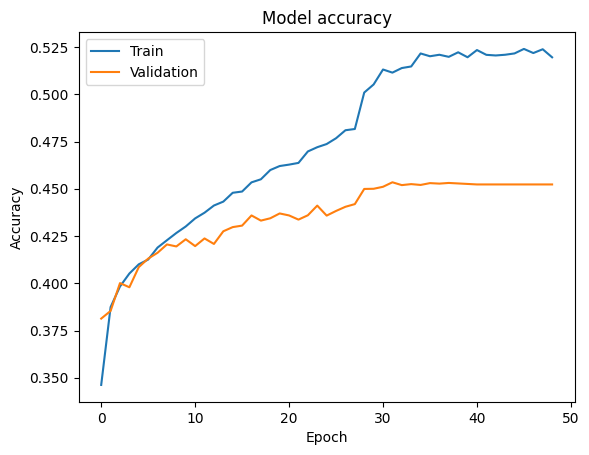

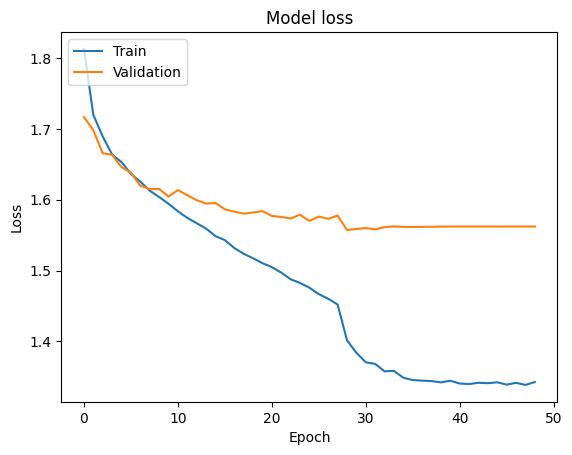

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               6144      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [18]:
loss, accuracy = model.evaluate(X_test_sc, y_test)
print(f'Test Accuracy: {accuracy}')
print(f'Test Loss: {loss}')

197/197 [==============================] - 0s 1ms/step - loss: 1.5817 - accuracy: 0.4503
Test Accuracy: 0.45031747221946716
Test Loss: 1.5817452669143677


In [19]:
y_pred_probs = model.predict(X_test_sc)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

197/197 [==============================] - 0s 837us/step


<Figure size 20000x20000 with 0 Axes>

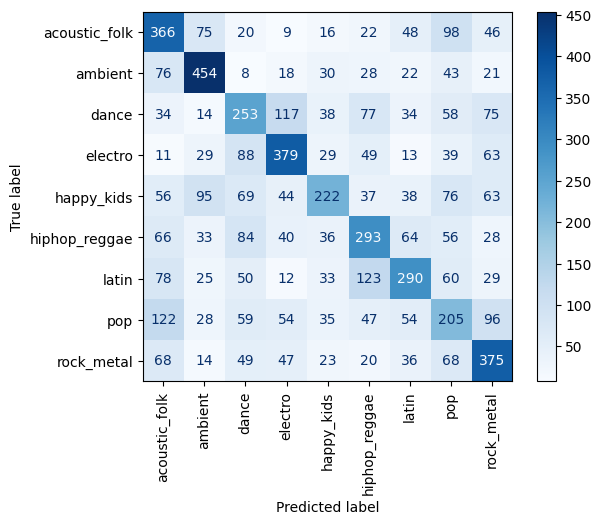

In [20]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.categories_[0])
plt.figure(figsize=(200,200))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation = 90);

In [21]:
df = pd.read_csv("nowplaying_cleaned.csv", index_col =0)

In [22]:
df.head()

,sentiment,sentiment_score,user_id,track_id,instrumentalness,liveness,speechiness,danceability,valence,loudness,...,acousticness,energy,mode,key,tz_Alaska_Time,tz_Central_Time,tz_Eastern_Time,tz_Hawaii_Time,tz_Mountain_Time,tz_Pacific_Time
0,1,2.4,252330820,8f2ac86abb8bd48273c8fc95b632e347,0.000000,0.1980,0.1690,0.461,0.502,-9.046,...,0.100000,0.628,0,4.0,0,0,1,0,0,0
1,1,2.4,29235188,45bbd6d7cd65dc77596af8c5c0b89a70,0.000010,0.0454,0.0451,0.677,0.886,-13.237,...,0.031300,0.544,0,11.0,0,0,1,0,0,0
2,1,0.6,29235188,45bbd6d7cd65dc77596af8c5c0b89a70,0.000010,0.0454,0.0451,0.677,0.886,-13.237,...,0.031300,0.544,0,11.0,0,0,1,0,0,0
6,0,0.3,124052165,d53b2de022666067050dae8f6645edc2,0.000142,0.1130,0.0709,0.355,0.118,-4.054,...,0.000004,0.980,0,7.0,1,0,0,0,0,0
7,1,0.6,62635490,2ac754eb153631a50e64b0b37801ef21,0.069000,0.3880,0.0390,0.697,0.630,-5.628,...,0.003310,0.917,1,1.0,0,0,1,0,0,0


Bringing the columns into the right order

In [23]:
#Storing the order of the training set columns in a list
column_order = data.columns.tolist()
column_order


['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [24]:
df.columns

Index(['sentiment', 'sentiment_score', 'user_id', 'track_id',
       'instrumentalness', 'liveness', 'speechiness', 'danceability',
       'valence', 'loudness', 'tempo', 'acousticness', 'energy', 'mode', 'key',
       'tz_Alaska_Time', 'tz_Central_Time', 'tz_Eastern_Time',
       'tz_Hawaii_Time', 'tz_Mountain_Time', 'tz_Pacific_Time'],
      dtype='object')

In [25]:
df.drop(["sentiment", "sentiment_score", "user_id", "track_id",  'tz_Alaska_Time', 'tz_Central_Time', 'tz_Eastern_Time','tz_Hawaii_Time', 'tz_Mountain_Time', 'tz_Pacific_Time'], axis=1, inplace=True)

In [26]:
df_ordered = df[column_order]

In [27]:
df_ordered.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

In [28]:
#Making sure colums are in the right order
df_ordered.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.461,0.628,4.0,-9.046,0,0.1690,0.100000,0.000000,0.1980,0.502,143.055
1,0.677,0.544,11.0,-13.237,0,0.0451,0.031300,0.000010,0.0454,0.886,77.837
2,0.677,0.544,11.0,-13.237,0,0.0451,0.031300,0.000010,0.0454,0.886,77.837
6,0.355,0.980,7.0,-4.054,0,0.0709,0.000004,0.000142,0.1130,0.118,130.427
7,0.697,0.917,1.0,-5.628,1,0.0390,0.003310,0.069000,0.3880,0.630,118.045


In [29]:
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
99940,0.487,0.184,0,-10.405,1,0.0377,0.634,0.000000,0.150,0.274,112.365
7162,0.553,0.567,0,-7.814,1,0.0294,0.262,0.000057,0.143,0.404,122.828
582,0.534,0.492,4,-8.905,1,0.0261,0.584,0.000001,0.185,0.328,82.465
34081,0.688,0.492,5,-8.459,1,0.0256,0.492,0.000227,0.147,0.638,107.918
102412,0.678,0.479,9,-8.030,1,0.0312,0.402,0.000000,0.200,0.619,92.532


In [30]:
new_data = scaler.transform(df_ordered)
predicted_genres = encoder.inverse_transform(model.predict(new_data))


69797/69797 [==============================] - 62s 881us/step


In [31]:
len(predicted_genres)

2233479

In [32]:
#Re-importing original dataframe to restore the previously deleted columns
df = pd.read_csv("nowplaying_cleaned.csv", index_col =0)

In [33]:
#joining the predicted genres to the dataframe
df["predicted_genres"] = predicted_genres

In [34]:
df.head()

,sentiment,sentiment_score,user_id,track_id,instrumentalness,liveness,speechiness,danceability,valence,loudness,...,energy,mode,key,tz_Alaska_Time,tz_Central_Time,tz_Eastern_Time,tz_Hawaii_Time,tz_Mountain_Time,tz_Pacific_Time,predicted_genres
0,1,2.4,252330820,8f2ac86abb8bd48273c8fc95b632e347,0.000000,0.1980,0.1690,0.461,0.502,-9.046,...,0.628,0,4.0,0,0,1,0,0,0,hiphop_reggae
1,1,2.4,29235188,45bbd6d7cd65dc77596af8c5c0b89a70,0.000010,0.0454,0.0451,0.677,0.886,-13.237,...,0.544,0,11.0,0,0,1,0,0,0,hiphop_reggae
2,1,0.6,29235188,45bbd6d7cd65dc77596af8c5c0b89a70,0.000010,0.0454,0.0451,0.677,0.886,-13.237,...,0.544,0,11.0,0,0,1,0,0,0,hiphop_reggae
6,0,0.3,124052165,d53b2de022666067050dae8f6645edc2,0.000142,0.1130,0.0709,0.355,0.118,-4.054,...,0.980,0,7.0,1,0,0,0,0,0,rock_metal
7,1,0.6,62635490,2ac754eb153631a50e64b0b37801ef21,0.069000,0.3880,0.0390,0.697,0.630,-5.628,...,0.917,1,1.0,0,0,1,0,0,0,dance


In [35]:
df.predicted_genres.value_counts()

rock_metal       490104
acoustic_folk    418517
pop              309748
dance            255991
electro          202302
ambient          173532
hiphop_reggae    153107
latin            137767
happy_kids        92411
Name: predicted_genres, dtype: int64

# Combining the Neural Network with a Random Forest Classifier

In [45]:
# Extract features from the neural network (use the output layer for simplicity)
nn_features_train = model.predict(X_train)
nn_features_test = model.predict(X_test)

# Combine neural network features with original features
X_train_combined = np.hstack((X_train, nn_features_train))
X_test_combined = np.hstack((X_test, nn_features_test))

# Train the Random Forest model
rf_model = RandomForestClassifier(max_depth = 20, min_samples_leaf=1, n_estimators=300, n_jobs=-1, random_state = 321)
rf_model.fit(X_train_combined, np.argmax(y_train, axis=1))

# Make predictions with the Random Forest model
rf_predictions = rf_model.predict(X_test_combined)


197/197 [==============================] - 0s 987us/step


In [46]:
# Evaluate the combined model
accuracy = accuracy_score(np.argmax(y_test, axis=1), rf_predictions)
print(f'Combined Model Test Accuracy: {accuracy}')


Combined Model Test Accuracy: 0.5079365079365079


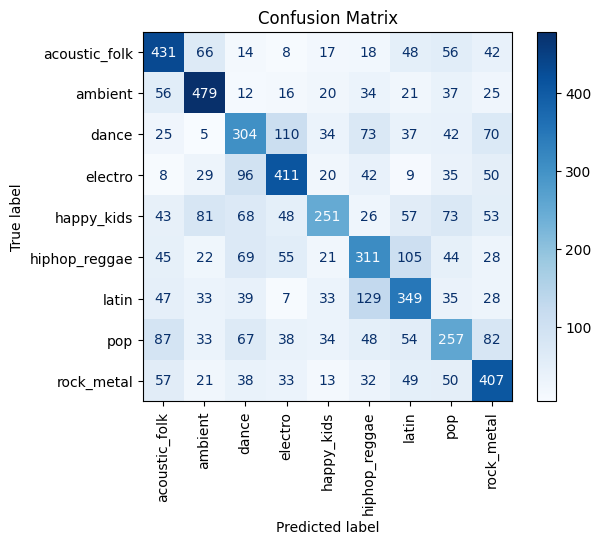

In [47]:
# Generate confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), rf_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.categories_[0])
disp.plot(cmap=plt.cm.Blues)

# Display the confusion matrix
plt.title('Confusion Matrix')
plt.xticks(rotation = 90)
plt.show();